<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
!pip3 install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

# импортируем функцию для построения автокорреляционной функции (ACF)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import catboost as ctb
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 

# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# импортируем класс модели SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression # для создания модели линейной регрессии

In [3]:
RANDOM_STATE = 42

pd.set_option('display.max_rows', 500)

In [4]:
# Загрузка данных
url_local = '/datasets/taxi.csv'
url_global = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(url_local):
    data = pd.read_csv(url_local, sep = ',', index_col=[0], parse_dates=[0])
else:
    data = pd.read_csv(url_global, sep = ',', index_col=[0], parse_dates=[0])

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [9]:
# Рэсемплирование по 1 часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


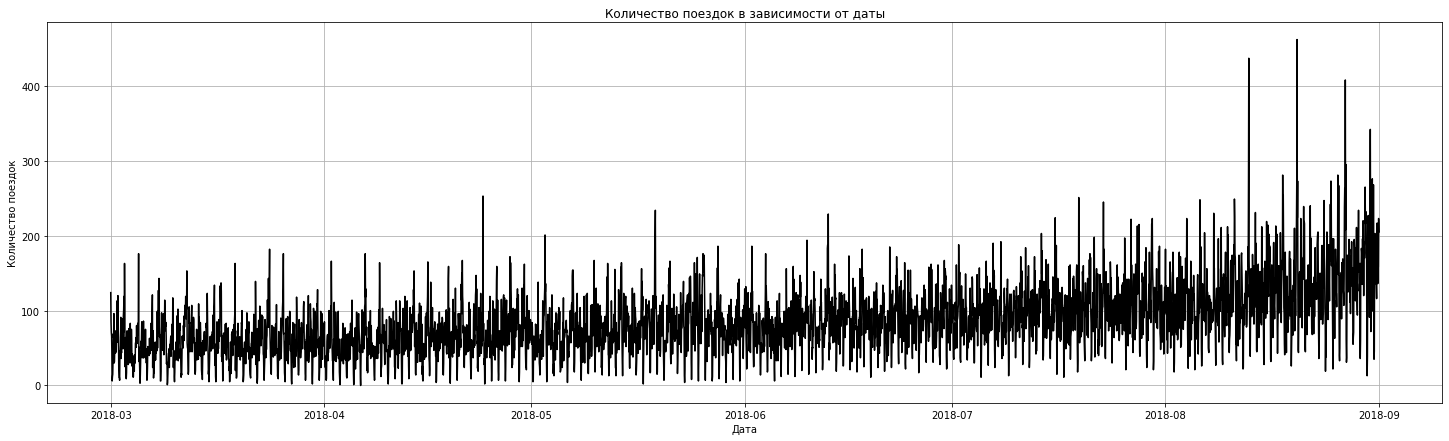

In [10]:
# Посмотрим, что получилось на графике:
plt.figure(figsize=(25, 7))
plt.plot(data, color = "black")
 
# заголовок и подписи к осям
plt.title('Количество поездок в зависимости от даты')
plt.ylabel('Количество поездок')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()

#data.plot(figsize=(25, 7) );

Предположительно, что минимальная цикличность является 24 часа, то сделаем скользящее среднее за 24 часа.

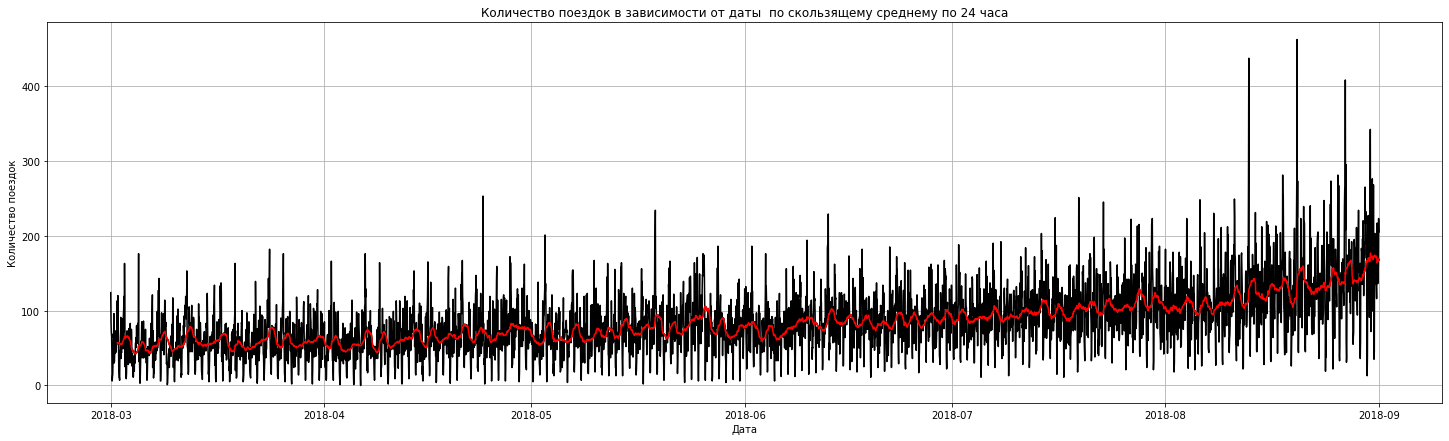

In [11]:
data_plot = data.copy()

# График с роллнгом на 24 часа
data_plot['rolling_mean'] = data_plot.rolling(24).mean()

plt.figure(figsize=(25, 7))
plt.plot(data_plot, color = "black")
plt.plot(data_plot['rolling_mean'], color = "red")

# заголовок и подписи к осям
plt.title('Количество поездок в зависимости от даты  по скользящему среднему по 24 часа')
plt.ylabel('Количество поездок')
plt.xlabel('Дата')

# добавим сетку
plt.grid()

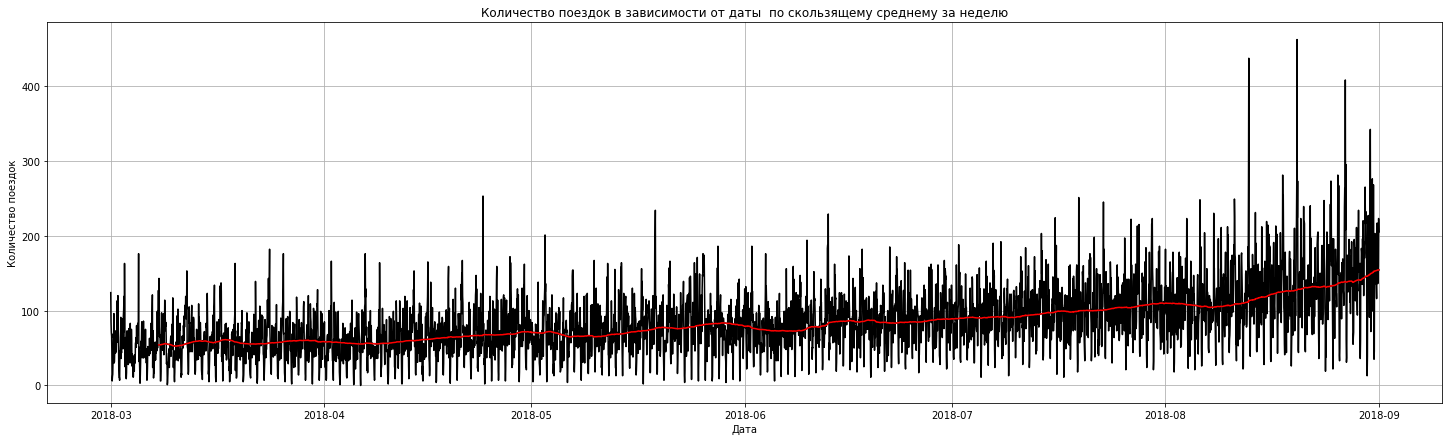

In [12]:
data_plot = data.copy()

# График с роллнгом на неделе
data_plot['rolling_mean'] = data_plot.rolling(24*7).mean()

plt.figure(figsize=(25, 7))
plt.plot(data_plot, color = "black")
plt.plot(data_plot['rolling_mean'], color = "red")

# заголовок и подписи к осям
plt.title('Количество поездок в зависимости от даты  по скользящему среднему за неделю')
plt.ylabel('Количество поездок')
plt.xlabel('Дата')

# добавим сетку
plt.grid()

Кривая по недельной скользящей средней еще более сильнее сгладилась.

__Выводы__


*   пропуски в датасете отсутствуют.
*   часовая разбивка в датасете
*   период март-август 2018 года



## Анализ

In [13]:
data.resample('1D').sum().head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


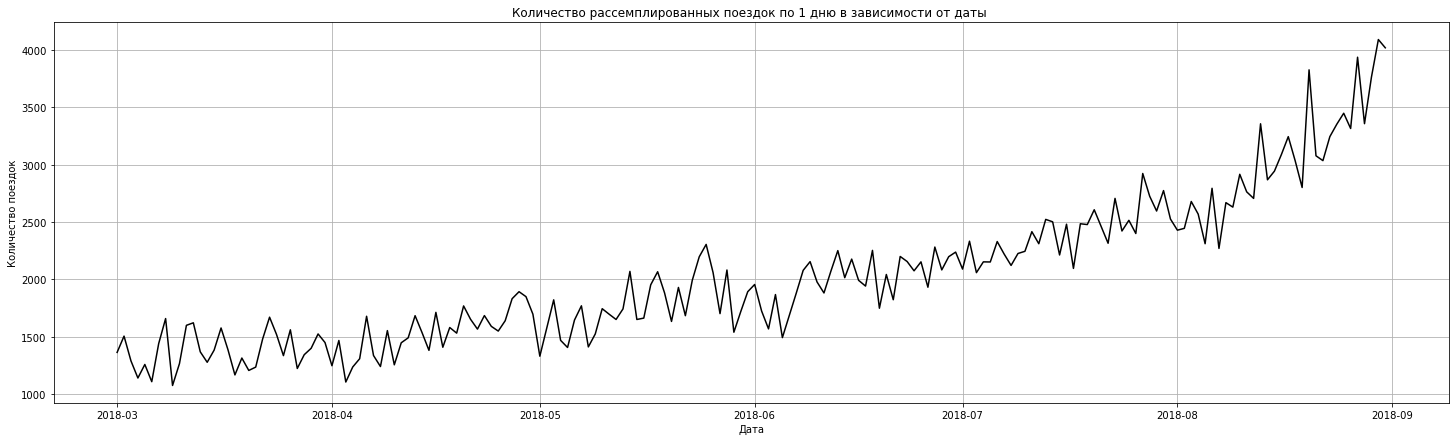

In [14]:
data_dayly = data.resample('1D').sum()

plt.figure(figsize=(25, 7))
plt.plot(data_dayly, color = "black")

# заголовок и подписи к осям
plt.title('Количество рассемплированных поездок по 1 дню в зависимости от даты ')
plt.ylabel('Количество поездок')
plt.xlabel('Дата')

# добавим сетку
plt.grid()

Разложим временный ряд data_dayly на компоненты: тренд, сезонность, случайные колебания.

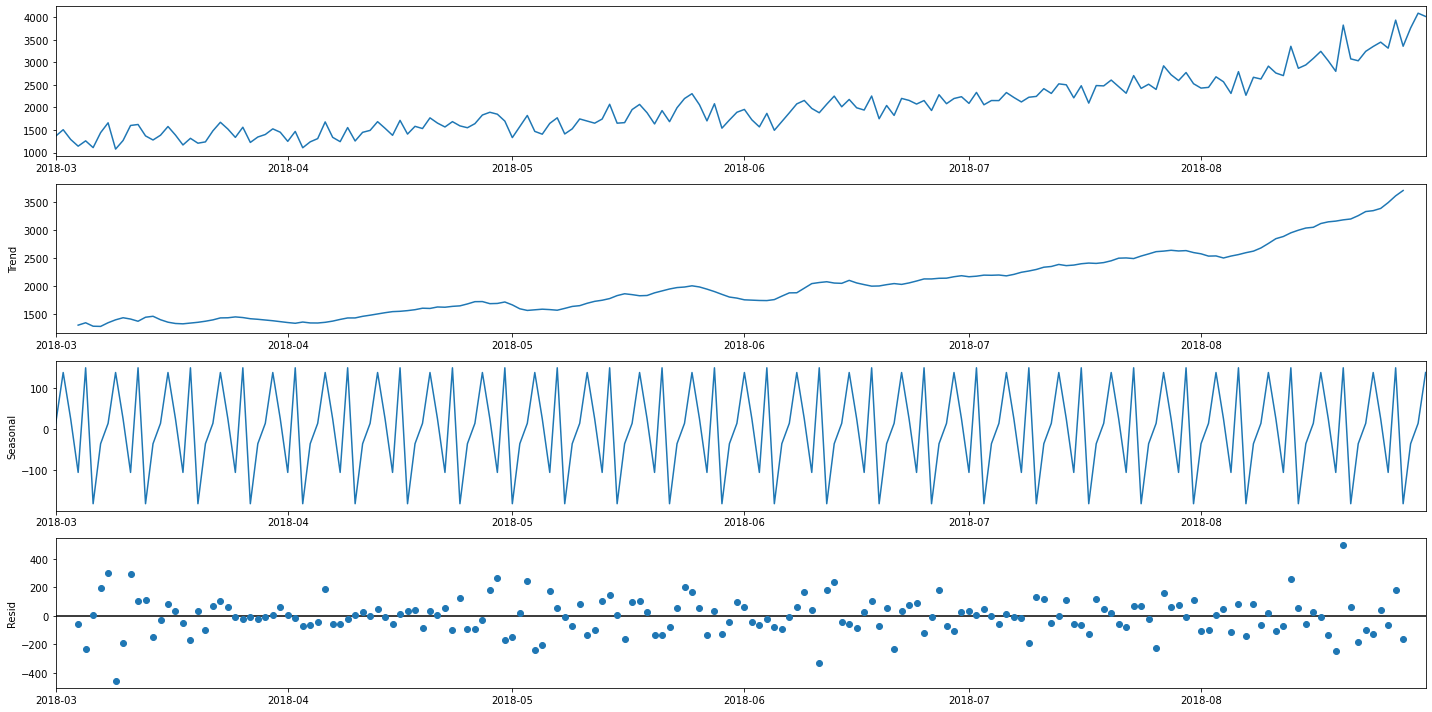

In [15]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(data_dayly)
decompose.plot()
 
plt.show()

__Промежуточные выводы__

По декомпозиции видно наличие восходящего тренда и определенной сезонности. Также имеется средний уровень случайных колебаний.

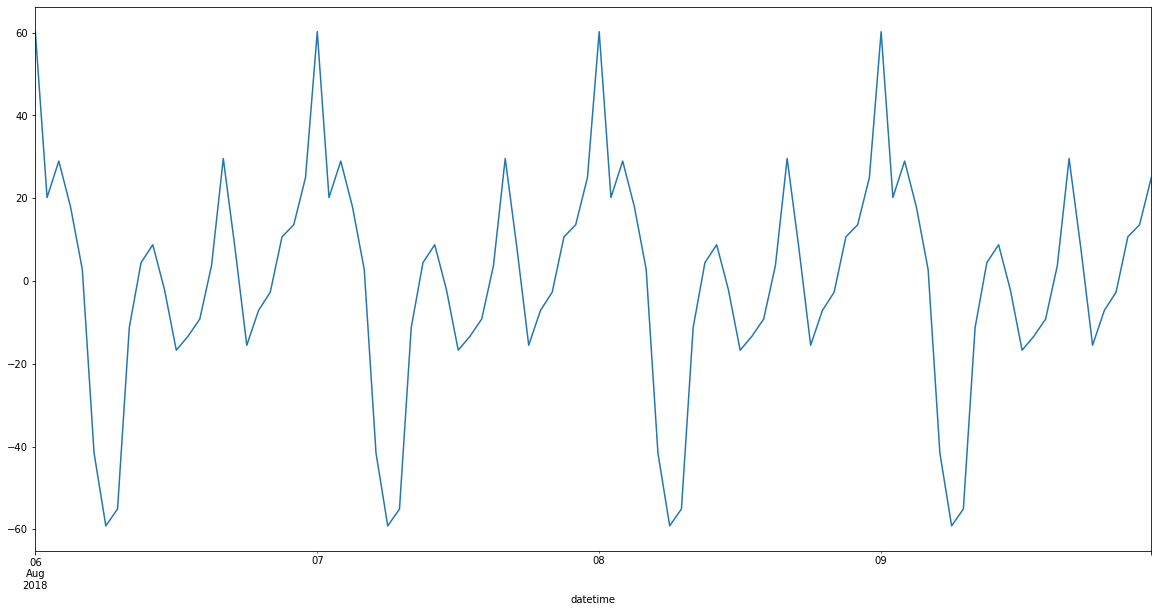

In [16]:
# применяем функцию к данным о перевозках
decompose_hour = seasonal_decompose(data)
decompose_hour.seasonal['2018-08-06':'2018-08-09'].plot(ax=plt.gca());

__Выводы__

Отмечается ежедневная сезонность, которая характерезуется ростом заказов в 24:00 и значительным снижением в 6:00.

### Стационарность

Так как планируется последующее моделирование, то необходимо определить стационарность. На графиках тренда (имеется) и сезонности (имеется) можно 
определить стационарность временного ряда data. Но проверим его через тест Дики-Фуллера по статистическому выводу.

В данном случае гипотезы звучат следующим образом.


*   Нулевая гипотеза предполагает, что процесс нестационарный
*   Альтернативная гипотеза соответственно говорит об обратном

Используем пороговое значение, равное 0,05 (5%).





In [17]:
# импортируем необходимую функцию 
from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(data.num_orders)
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.02894005140261315


Вероятность (p-value) для данных о перевозках существенно ниже 0,05. Отвергаем нулевую гипотезу. Процесс НЕ станионарный. 

### Автокорреляция

Посмотрим на автокорреляцию

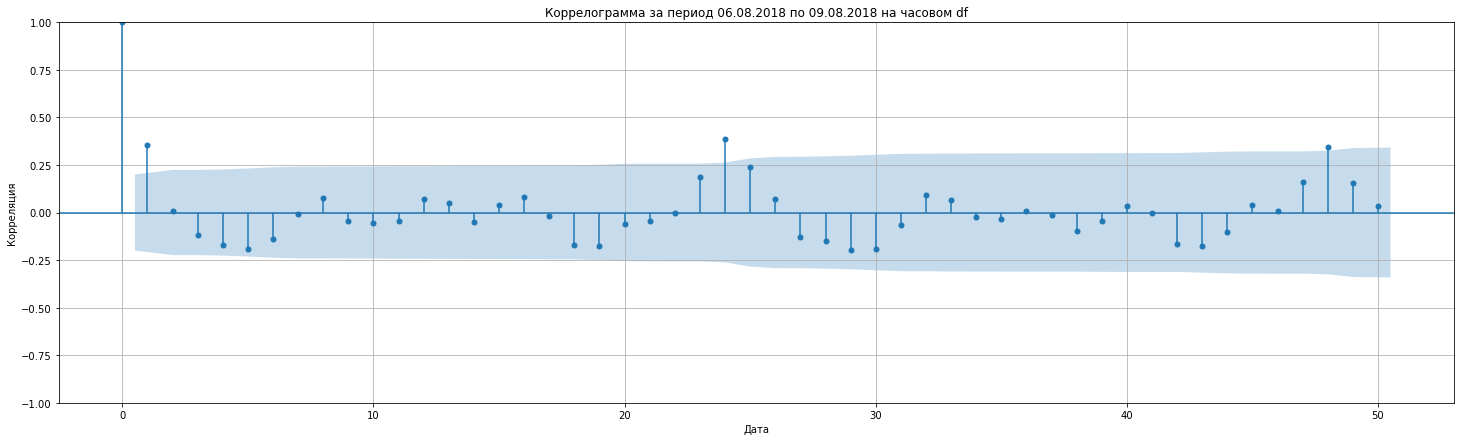

In [18]:
# применим ее к данным о поездках
N, M = 25, 7
fig, ax = plt.subplots(figsize=(N, M))

plot_acf(data['2018-08-06':'2018-08-09'], ax=ax, lags=50)

#plot_acf(data['2018-08-06':'2018-08-09'])

# заголовок и подписи к осям
plt.title('Коррелограмма за период 06.08.2018 по 09.08.2018 на часовом df')
plt.ylabel('Корреляция')
plt.xlabel('Дата')

# добавим сетку
plt.grid()

plt.show();

По графику автокорреляции видно, что каждое предыдущее значение (каждый предыдущий час) имеет незначииельную корреляцию с предыдущим. Также видна цикличность каждые 24 значения (каждые 24 часа).

__Выводы__:

Произведен анализ данных исходного датасета (по часам). 
После семплирования по 1 дню выявлен восходящий тренд и сзеонность.
На декомпозиции по исходному датасету видна значимая корреляция.
Произведена проверка на стационарность ряда. Ряд являетсястационарным.

### Выводы

* Имеющийся тренд (восходящий)
* Вывлена сезонность (по часам и неделям). Месяцная не рассматоривалась.
* Изучена стационарность часового ряда. По критерию Дикки-Фуллера ряд не стационарен.


## Обучение

In [19]:
# Таблица для результатов обучения молелей.

model_rep = pd.DataFrame({"Model": [],
                          "RMSE": []
                          })

Добавим новые признаки

In [20]:
data['day_of_week'] = data.index.dayofweek                                   # день недели
data['hour'] = data.index.hour                                                # часа в сутках
data['rolling'] = data['num_orders'].shift().rolling(7).mean()                # Скольжение на 4 по среднему арифметическому
#data['lag1'] = data['num_orders'].shift(1)                                    # Отстающее значение (на 1)
data.head()

,num_orders,day_of_week,hour,rolling
datetime,,,,
2018-03-01 00:00:00,124,3,0,NaN
2018-03-01 01:00:00,85,3,1,NaN
2018-03-01 02:00:00,71,3,2,NaN
2018-03-01 03:00:00,66,3,3,NaN
2018-03-01 04:00:00,43,3,4,NaN


In [21]:
# Сделаем разбивку на тестовую и обучающую

X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False,
                                                    test_size=0.1)

# проверим
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3974, 3), (442, 3), (3974,), (442,))

### CatBoostRegressor

In [22]:
%%time
model_CBR = ctb.CatBoostRegressor(iterations = 100,
                                  random_state=RANDOM_STATE, 
                                  verbose=False)

params = [{
    'depth': range(2, 12, 3), # глубина дерева
    'iterations': range(250, 301, 50), # количество итераций
    'learning_rate': [0.05, 0.1, 0.15], # коэффициент скорости обучения (размер шага градиентного спуска)
}]
model_CBR_GS = GridSearchCV(model_CBR, params,
                   cv=TimeSeriesSplit(n_splits=5),
                   scoring='neg_mean_squared_error')
model_CBR_GS.fit(X_train, y_train);

CPU times: total: 2min 13s
Wall time: 3min 38s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000022D992405E0>,
             param_grid=[{'depth': range(2, 12, 3),
                          'iterations': range(250, 301, 50),
                          'learning_rate': [0.05, 0.1, 0.15]}],
             scoring='neg_mean_squared_error')

In [23]:
model_rep = model_rep.append({"Model": 'CatBoostRegressor',
                          "RMSE": round((model_CBR_GS.best_score_ * -1)**0.5, 2)
                          },
                         ignore_index=True)
model_rep

,Model,RMSE
0,CatBoostRegressor,26.09


Преодолен целевой уровень RMSE. Но сделаем еще одну модель по аналогичному принципу (с бустингом) - LGBM Regressor.

### LGBM Regressor

In [24]:
%%time
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE)

params = [{
    'learning_rate': [0.01, 0.05, 0.1], # коэффициент скорости обучения (размер шага градиентного спуска)
    'max_depth': range(4, 9, 2), # максимальная глубина дерева
    'n_estimators': range(100, 201, 50), # количество деревьев (итераций)
}]

model_LGBM_GS = GridSearchCV(model_LGBM, params,
                   cv=TimeSeriesSplit(n_splits=5),
                   scoring='neg_mean_squared_error')
model_LGBM_GS.fit(X_train, y_train);

CPU times: total: 19.4 s
Wall time: 9.57 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': range(4, 9, 2),
                          'n_estimators': range(100, 201, 50)}],
             scoring='neg_mean_squared_error')

In [25]:
model_rep = model_rep.append({"Model": 'LGBMRegressor',
                          "RMSE": round((model_LGBM_GS.best_score_ * -1)**0.5, 2)
                          },
                         ignore_index=True)
model_rep

,Model,RMSE
0,CatBoostRegressor,26.09
1,LGBMRegressor,26.13


Попробуем построить линейную модель.

### Linear Model

In [26]:
%%time
model_LM = LinearRegression()
model_LM.fit(X_train[10:], y_train[10:]) # Отрезал начало из-за Null

scores_list = cross_val_score(estimator=model_LM, 
                              X=X_train[10:], 
                              y=y_train[10:], 
                              cv=TimeSeriesSplit(n_splits=5),  
                              scoring='neg_mean_squared_error')

val_score = - scores_list.mean()
val_score

CPU times: total: 46.9 ms
Wall time: 29.9 ms


1387.683586208781

In [27]:
model_rep = model_rep.append({"Model": 'Linear Model',
                          "RMSE": val_score**0.5
                          },
                         ignore_index=True)
model_rep

,Model,RMSE
0,CatBoostRegressor,26.090000
1,LGBMRegressor,26.130000
2,Linear Model,37.251625


Линейная модель ожидаемо показала самый худший результат.

__Выводы__

Категориальный бустинг оказался лучше. Жаль, что создатели Яндекса не смогли сделать руссифицированный мануал.

### SARIMAX (дневной датасет)

Попробуем разделить на обучающую и тестовую (10%) выборку.

In [28]:
data_dayly.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [29]:
train_len = round(len(data_dayly) * 0.89)
train = data_dayly[:train_len]
train.tail()

,num_orders
datetime,
2018-08-07,2270
2018-08-08,2669
2018-08-09,2630
2018-08-10,2916
2018-08-11,2763


In [30]:
test = data_dayly[train_len:]
test.head()

,num_orders
datetime,
2018-08-12,2706
2018-08-13,3356
2018-08-14,2868
2018-08-15,2943
2018-08-16,3087


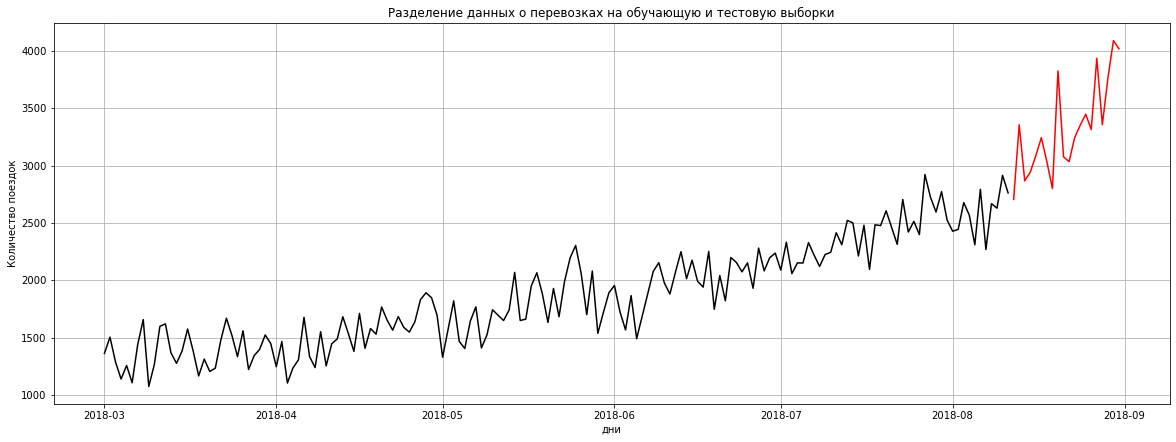

In [31]:
# Посмотрим, что получилось на графике:
plt.figure(figsize=(20, 7))
plt.plot(train['num_orders'], color = "black")
plt.plot(test['num_orders'], color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество поездок')
plt.xlabel('дни')
 
# добавим сетку
plt.grid()
plt.show()

Попробуем предсказать значение. Далее нам нужно обучить модель. При обучении модели SARIMAX, самое важное — правильно подобрать гиперпараметры. Очевидно, как камень каменный.

In [32]:
# создадим объект этой модели
model = SARIMAX(train, 
                order = (2, 0, 2), 
                seasonal_order = (0, 1, 0, 24))
 
# применим метод fit
result = model.fit()

Теперь можно делать прогноз. Вначале сделаем тестовый прогноз, соответствующий периоду тестовой выборки, для того, чтобы оценить качество работы модели.

In [33]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions[:5]

2018-08-12    2539.176534
2018-08-13    2994.666318
2018-08-14    2562.468594
2018-08-15    2664.768390
2018-08-16    2839.512644
Freq: D, Name: predicted_mean, dtype: float64

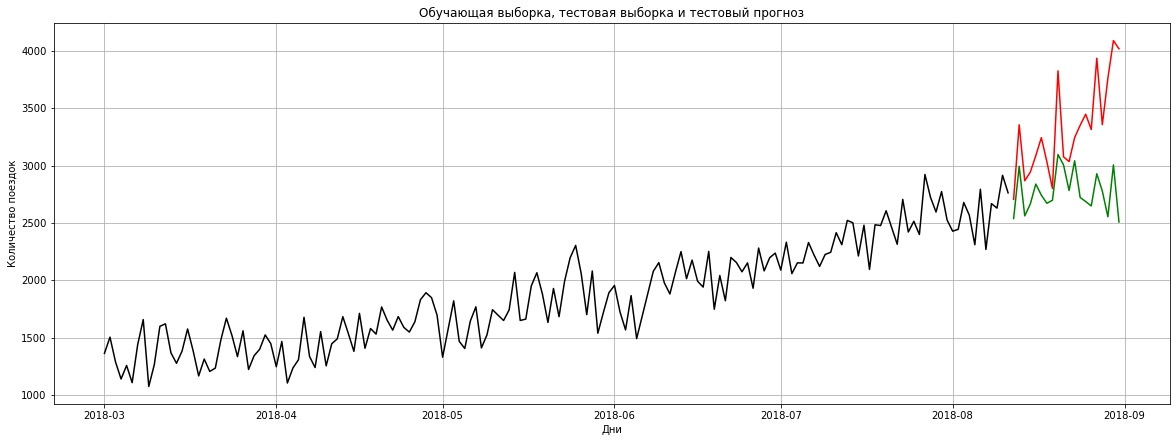

In [34]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(20, 7))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество поездок')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

In [35]:
print('RMSE', np.sqrt(mean_squared_error(test, predictions))**0.5)

RMSE 25.97207387241832


## Тестирование

В блоке тестирования необходимо использовать тестовые данные )) по обученной CatBoost

In [36]:
X_test.shape, y_test.shape

((442, 3), (442,))

In [37]:
mean_squared_error(model_CBR_GS.predict(X_test), y_test)**0.5

45.033137323384345

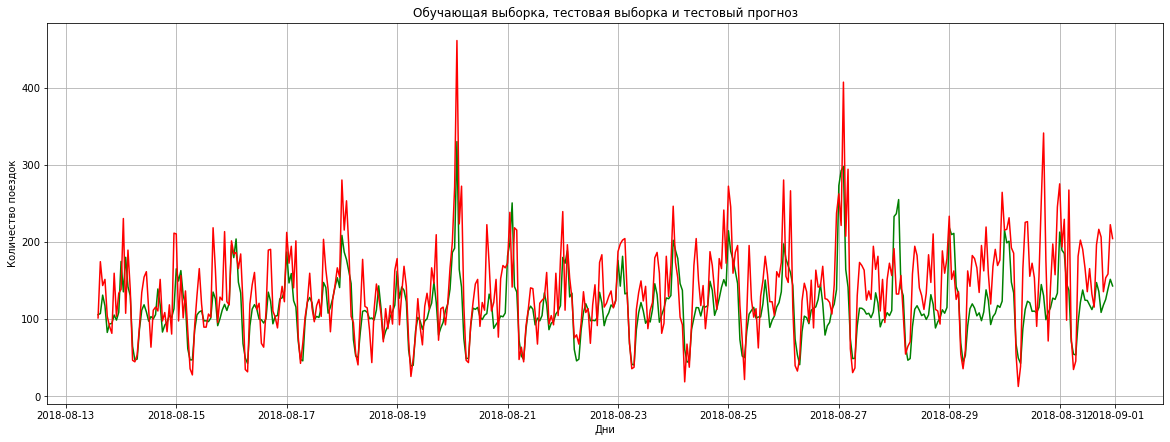

In [38]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
test = X_test['day_of_week']
train = X_train['day_of_week']

plt.figure(figsize=(20, 7))
#plt.plot(train, color = "black")
#plt.plot(test, color = "red")
plt.plot(pd.DataFrame(model_CBR_GS.predict(X_test),index=y_test.index), label='предсказанное значение (predict)', color = "green", )
plt.plot(y_test, color = "red", label='фактическое значение (test)',)
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество поездок')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
plt.show()

__Выводы__
В рамках работы были сделаны:



*   EDA: анализ на пропуски, рассемплирование (разные сроки), анализ автокоррекляции. В рамках анализа выявлена дневная и недельная сезонности.
*   Обучение: добавлены новые признаки - день недели, часы в сутках, скольжение на 7 по среднему арифметическому
*   Тестирование: на выборке на 10% значениях показало значение 45,8, что соответствует необходимому.
*  Факультативно реальзован SARIMAX по дневным данным.
* Наилучшая модель оказалась CatBoost с RMSE на тесте 45.03 